## This notebook is for Google Colab.
## It contains the script to buil graphs from the experiment results.

In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pwd

/content


In [3]:
!rm -rf Liubov_Tovbin

In [4]:
%mkdir Liubov_Tovbin
%cd Liubov_Tovbin

/content/Liubov_Tovbin


In [5]:
!git clone https://github.com/LubaTovbin/CMPE-260

Cloning into 'CMPE-260'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 780 (delta 8), reused 0 (delta 0), pack-reused 749
Receiving objects: 100% (780/780), 48.76 MiB | 18.80 MiB/s, done.
Resolving deltas: 100% (309/309), done.


In [6]:
%cd CMPE-260

/content/Liubov_Tovbin/CMPE-260


In [7]:
!pip install git+https://github.com/quantopian/pyfolio

  Cloning https://github.com/quantopian/pyfolio to /tmp/pip-req-build-tfqxovv1
  Running command git clone -q https://github.com/quantopian/pyfolio /tmp/pip-req-build-tfqxovv1
  Created wheel for pyfolio: filename=pyfolio-0.9.2+75.g4b901f6-cp36-none-any.whl size=75766 sha256=d97922252b367a9421382fb0c8e899891978e4d0dc202e85a9f1ee35c46e5112
  Stored in directory: /tmp/pip-ephem-wheel-cache-r4m4b9bh/wheels/62/7d/a7/3e462442ba7d63c35414176627c886340521dc3dbc0893ce9f
Successfully built pyfolio


In [8]:
# Source: 
# https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pyfolio

/usr/local/lib/python3.6/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [9]:
import zipfile
with zipfile.ZipFile('original_and_modified_models_results.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [10]:
def backtest_strat(df):
    strategy_ret= df.copy()
    strategy_ret['Date'] = pd.to_datetime(strategy_ret['Date'])
    strategy_ret.set_index('Date', drop = False, inplace = True)
    strategy_ret.index = strategy_ret.index.tz_localize('UTC')
    del strategy_ret['Date']
    ts = pd.Series(strategy_ret['daily_return'].values, index=strategy_ret.index)
    return ts

In [11]:
# Concatenate all the account_value_trade data files
# 18 data files, 63 records each
# 18*63 = 1134 entries

def get_account_value(path, model_name):
    df_account_value=pd.DataFrame()
    for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
        temp = pd.read_csv(path + '/account_value_trade_{}_{}.csv'.format(model_name,i))
        df_account_value = df_account_value.append(temp,ignore_index=True)
    df_account_value = pd.DataFrame({'account_value':df_account_value['0']})
    sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
    print('Sharpe ratio for = ',sharpe)
    df_account_value=df_account_value.join(df_trade_date[63:].reset_index(drop=True))
    return df_account_value

In [12]:
def get_daily_return(df):
    df['daily_return']=df.account_value.pct_change(1)
    #print('Sharpe: ',(252**0.5)*df['daily_return'].mean()/ df['daily_return'].std())
    return df

In [13]:
# read the whole data set
dji = pd.read_csv("data/^DJI.csv")

#  Take the data between 01/01/2016 and 06/30/2020 for testing
test_dji=dji[(dji['Date']>='2016-01-01') & (dji['Date']<='2020-06-30')]
test_dji = test_dji.reset_index(drop=True)
test_dji['daily_return']=test_dji['Adj Close'].pct_change(1)

In [14]:
dow_strat = backtest_strat(test_dji)

### Ensenmble strategy

In [15]:
df=pd.read_csv('data/dow_30_2009_2020.csv')

rebalance_window = 63
validation_window = 63
unique_trade_date = df[(df.datadate > 20151001)&(df.datadate <= 20200707)].datadate.unique()

# Add the date column
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

#### Retrive and concatemate all the account_value_trade files

In [16]:
%cd original_and_modified_models_results

/content/Liubov_Tovbin/CMPE-260/original_and_modified_models_results


In [17]:
ensemble_account_value_orig = get_account_value('original/results', "ensemble")
ensemble_account_value_turb_holdbuy = get_account_value('turb_hold_and_buy/results', "ensemble")
ensemble_account_value_turb_hold = get_account_value('turb_hold/results', "ensemble")

ensemble_account_value_short_vec = get_account_value('short_env_vec/results', "ensemble")
ensemble_account_value_lstm = get_account_value('MlpLstm/results', "ensemble")
ensemble_account_value_sortino = get_account_value('Sortino/results', "ensemble")
ensemble_account_value_multi_ppo = get_account_value('Multi-PPO/results', "ensemble")

Sharpe ratio for =  1.516111866014984
Sharpe ratio for =  0.41108746366896315
Sharpe ratio for =  0.3110239980254901
Sharpe ratio for =  1.2360145560550029
Sharpe ratio for =  1.119310910960868
Sharpe ratio for =  1.229088749586022
Sharpe ratio for =  1.2910388098379864


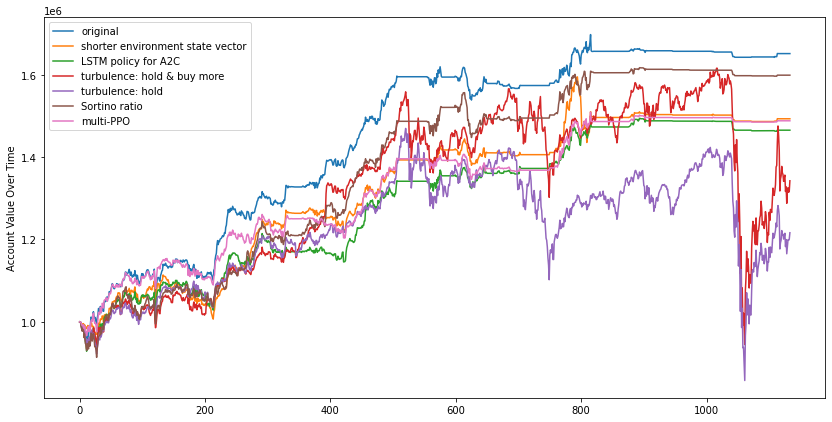

In [18]:
fig = plt.figure(figsize=(14,7))

ensemble_account_value_orig.account_value.plot(label='original')

ensemble_account_value_short_vec.account_value.plot(label='shorter environment state vector')
ensemble_account_value_lstm.account_value.plot(label='LSTM policy for A2C')

ensemble_account_value_turb_holdbuy.account_value.plot(label='turbulence: hold & buy more')
ensemble_account_value_turb_hold.account_value.plot(label='turbulence: hold')

ensemble_account_value_sortino.account_value.plot(label='Sortino ratio')
ensemble_account_value_multi_ppo.account_value.plot(label='multi-PPO')

plt.ylabel('Account Value Over Time')
plt.legend()

In [19]:
models = [ensemble_account_value_orig,
            ensemble_account_value_short_vec,
            ensemble_account_value_lstm,
            ensemble_account_value_turb_holdbuy,
            ensemble_account_value_turb_hold,
            ensemble_account_value_sortino,
            ensemble_account_value_multi_ppo
         ]

In [20]:
for model in models:
    model = get_daily_return(model)
    model['Date'] = test_dji['Date']

In [21]:
ensemble_account_value_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1134 entries, 0 to 1133
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   account_value  1134 non-null   float64
 1   datadate       1134 non-null   int64  
 2   daily_return   1133 non-null   float64
 3   Date           1131 non-null   object 
dtypes: float64(2), int64(1), object(1)
memory usage: 35.6+ KB


In [22]:
ensemble_account_value_orig.head()

,account_value,datadate,daily_return,Date
0,1.000000e+06,20160104,NaN,2016-01-04
1,1.000096e+06,20160105,0.000096,2016-01-05
2,9.963688e+05,20160106,-0.003727,2016-01-06
3,9.883389e+05,20160107,-0.008059,2016-01-07
4,9.844544e+05,20160108,-0.003930,2016-01-08


In [23]:
ensemble_strat_models = [backtest_strat(model[0:1097]) for model in models]

Start date,2016-01-04
End date,2020-05-12
Total months,52
,Backtest
Annual return,12.087%
Cumulative returns,64.332%
Annual volatility,7.672%
Sharpe ratio,1.53
Calmar ratio,2.15
Stability,0.85
Max drawdown,-5.626%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,5.63,2016-06-23,2016-06-27,2016-07-14,16
1,5.09,2016-01-05,2016-01-20,2016-01-29,19
2,4.99,2018-04-17,2018-06-27,2019-02-05,211
3,4.59,2016-08-11,2016-11-04,2016-11-10,66
4,3.25,2019-04-01,2020-03-02,NaT,NaN


/usr/local/lib/python3.6/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


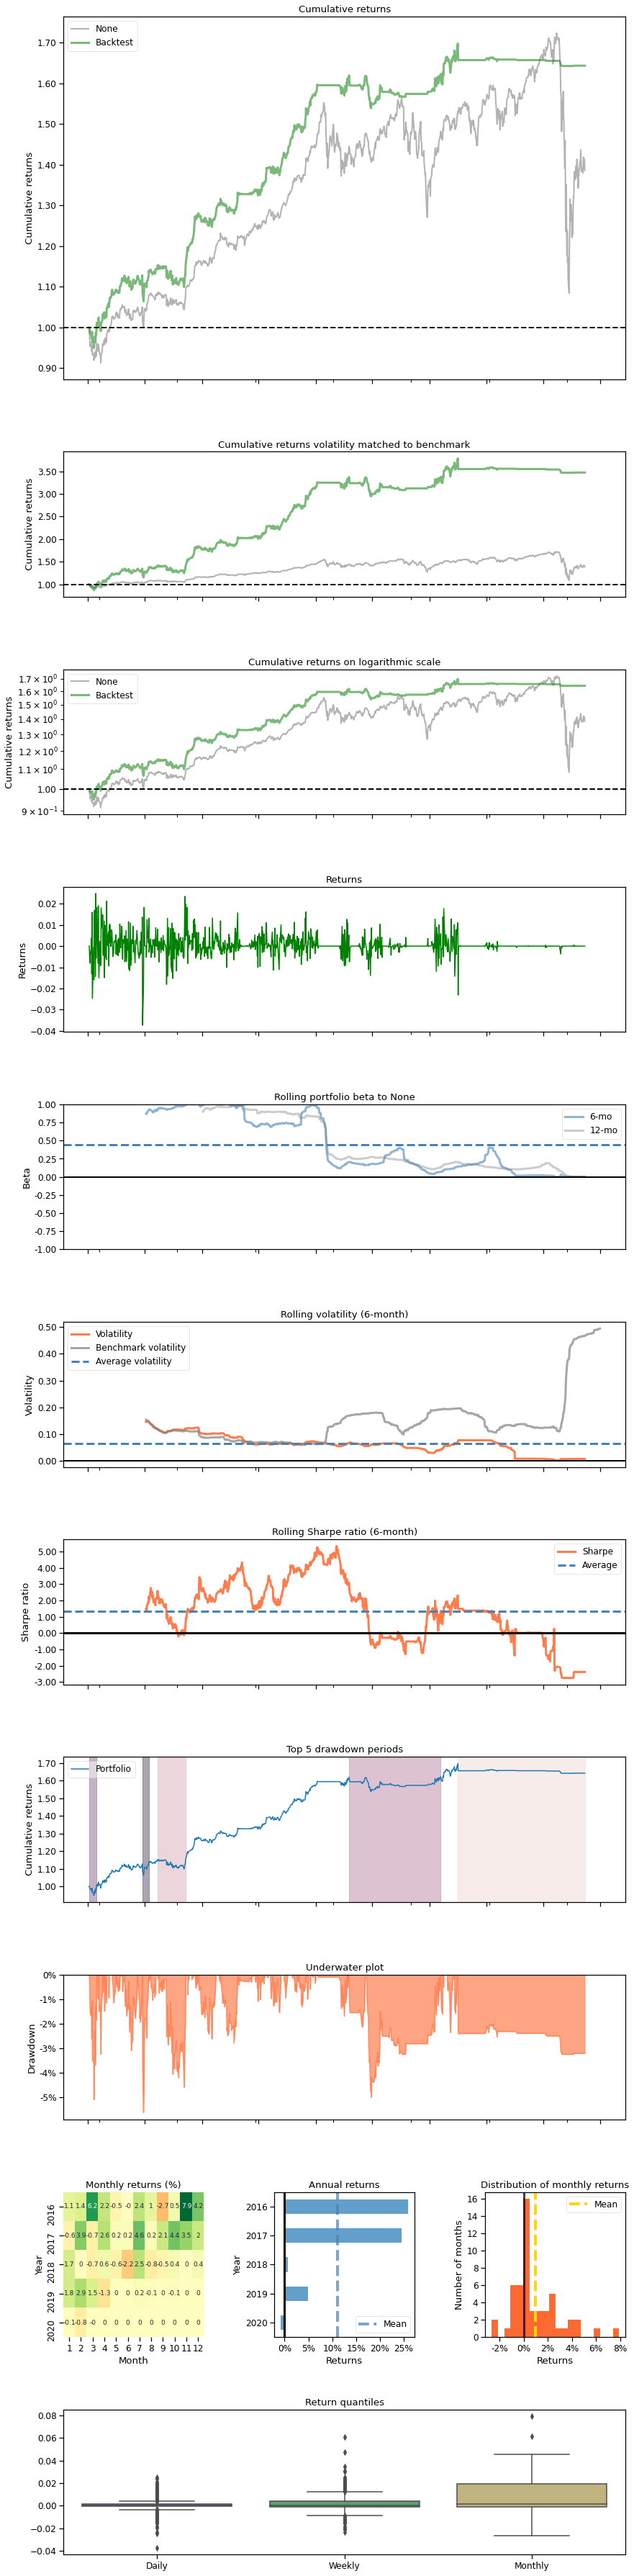

In [24]:
with pyfolio.plotting.plotting_context(font_scale=1.1):
    pyfolio.create_full_tear_sheet(returns = ensemble_strat_models[0],
                                   benchmark_rets=dow_strat,
                                   set_context=False)